In [1]:
!pip install grad-cam segmentation-models-pytorch --quiet

     |████████████████████████████████| 7.8 MB 16.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 97 kB 5.5 MB/s 
     |████████████████████████████████| 58 kB 2.6 MB/s 
     |████████████████████████████████| 376 kB 67.8 MB/s 


In [2]:
import numpy as np
import pandas as pd

import os

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
RANDOM_STATE = 42
GDRIVE = True

data_root = None
if GDRIVE:
    data_root = "/content/drive/MyDrive/GoogleColabProjects/FewShotKneeJointSpaceSegmentation/data/"

In [4]:
class GradCamSampler(nn.Module):
    def __init__(self, img_root, mask_root, image_files, mask_files, transforms=None, preprocessing=None, samples_to_generate=5):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.samples_to_generate = samples_to_generate
        self.transforms = transforms
        self.preprocessing = preprocessing

    def _sample_images_for_gradcam(self):
        sample_ids = np.random.choice(range(len(self.img_files)), size=self.samples_to_generate)
        self.ids = sample_ids

    def __len__(self):
        return self.samples_to_generate
    
    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_root, self.img_files[idx])))
        mask = np.array(Image.open(os.path.join(self.mask_root, self.mask_files[idx])))
        
        # image = np.stack([image, image, image], axis=-1)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        # mask = torch.unsqueeze(mask, 0)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image)
            image = transformed["image"]
            # mask = transformed["mask"]
            
        return image.type(torch.FloatTensor), mask/255.0

In [5]:
def generate_datasets(root_dir):
    x_dir = os.path.join(root_dir, "Train_X")
    y_dir = os.path.join(root_dir, "Train_Y")
    records = [[img.split(".")[0][:-1], img, img] for img in os.listdir(x_dir)]
 
    data_records = pd.DataFrame(records, columns=["pid", "images", "masks"])
    
    train, test = train_test_split(data_records.pid.unique(), test_size=0.5, random_state=42)
    valid, test = train_test_split(test, test_size=0.5, random_state=42)
    
    train = data_records[data_records.pid.isin(train)].reset_index(drop=True)
    valid = data_records[data_records.pid.isin(valid)].reset_index(drop=True)
    test = data_records[data_records.pid.isin(test)].reset_index(drop=True)

    return train, valid, test

In [6]:
_, _, test = generate_datasets(os.path.join(data_root, "images"))
augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()])

In [7]:
test_set = GradCamSampler(os.path.join(data_root, "images/Train_X"),
                                         os.path.join(data_root, "images/Train_Y"),
                                         test.images, test.masks, 
                                         preprocessing=None,#get_preprocessing(preprocessing_fn),
                                         transforms=augmentations)

In [36]:
model = torch.load(os.path.join(data_root, "unet_10shot_noaug.pth")) #"deeplabv3_10shot_noaug.pth"))

In [37]:
model = model.cuda()

In [38]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
test_img, test_mask  = next(iter(test_loader))

In [39]:
test_img = test_img.cuda()

In [40]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        if type(mask) == np.array:
            self.mask = torch.from_numpy(mask)
        else:
            self.mask = mask

        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        print(self.mask.shape == model_output.shape)
        return (model_output[self.category,:,:] * self.mask).sum()


In [41]:
classes = {
    0: "Background",
    1: "KneeJointSpace"
}

In [42]:
from sklearn.metrics import jaccard_score

True
(256, 256) (256, 256)
tensor(0.8172)
True
(256, 256) (256, 256)
tensor(0.7814)
True
(256, 256) (256, 256)
tensor(0.9062)
True
(256, 256) (256, 256)
tensor(0.9094)
True
(256, 256) (256, 256)
tensor(0.8983)


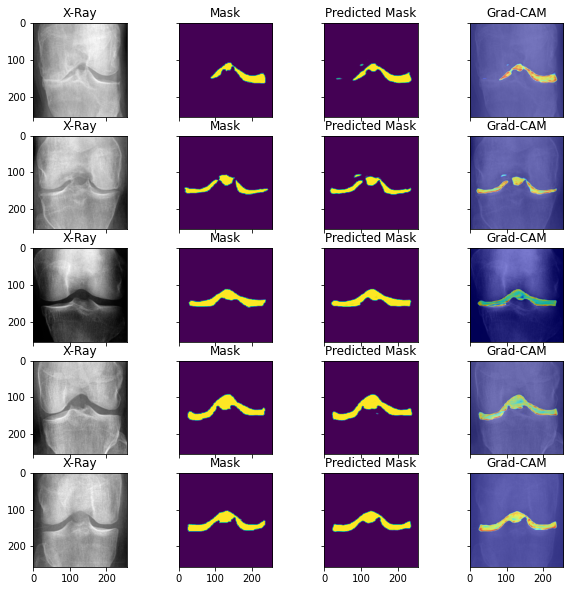

In [43]:
target_layers = [model.decoder, model.segmentation_head]
iou = smp_utils.metrics.IoU(threshold=0.5)
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:

    fig, ax = plt.subplots(len(test_loader), 4, figsize=(10, 10), sharex=True, sharey=True)

    for i, (test_img, test_mask) in enumerate(test_loader):
        targets = [SemanticSegmentationTarget(0, test_mask)]

        grayscale_cam = cam(input_tensor=test_img,
                            targets=targets)[0, :]

        test_img2= test_img.squeeze().squeeze().detach().cpu().numpy()/255.0
        test_img2 = np.stack([test_img2, test_img2, test_img2], axis=-1)

        cam_image = show_cam_on_image(test_img2, grayscale_cam, use_rgb=True)
        out = model(test_img.cuda())

        ax[i, 0].imshow(test_img[0][0,:,:].squeeze(),cmap="gray")
        ax[i, 0].set_title("X-Ray")
        ax[i, 1].imshow(test_mask.squeeze())
        ax[i, 1].set_title("Mask")
        ax[i, 2].imshow(torch.sigmoid(out).squeeze().detach().cpu().numpy())
        ax[i, 2].set_title("Predicted Mask")
        ax[i, 3].imshow(Image.fromarray(cam_image))
        ax[i, 3].set_title("Grad-CAM")

        print(test_mask.squeeze().numpy().shape,  torch.sigmoid(out).squeeze().detach().cpu().numpy().shape)
        print(iou(out.detach().cpu().squeeze(), test_mask.squeeze()))